In [1]:
import pandas as pd
import sys
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
products = pd.read_csv('../data/products.csv')
aisles = pd.read_csv('../data/aisles.csv')
departments = pd.read_csv('../data/departments.csv')
order_products_prior = pd.read_csv('../data/order_products__prior.csv')
order_products_train = pd.read_csv('../data/order_products__train.csv')
orders = pd.read_csv('../data/orders.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
#creating one big dataframe called all_orders with most of the features included. 
all_orders = pd.concat([order_products_prior,order_products_train])
all_orders = all_orders.merge(orders[['order_id','user_id']], on='order_id', how='inner')
all_orders = all_orders.merge(products, on = 'product_id', how='inner')
all_orders = all_orders.merge(departments, on = 'department_id', how='inner')
all_orders = all_orders.merge(aisles, on = 'aisle_id', how='inner')


In [4]:
#How many products the user bought from each aisle 
cnt_per_aisle = all_orders[['user_id','aisle','product_name']].groupby(['user_id', 'aisle']).count().reset_index() 

cnt_per_aisle = cnt_per_aisle.rename(columns={'product_name':'product_cnt_per_aisle'})

In [5]:
cnt_per_aisle

,user_id,aisle,product_cnt_per_aisle
0,1,candy chocolate,2
1,1,cereal,4
2,1,cream,3
3,1,fresh fruits,5
4,1,milk,1
...,...,...,...
5919835,206209,soft drinks,11
5919836,206209,soy lactosefree,10
5919837,206209,spices seasonings,1
5919838,206209,trash bags liners,1


In [6]:
#Total product purchased by user id 
ttl_per_user = cnt_per_aisle.groupby(["user_id"]).sum()
ttl_per_user

,product_cnt_per_aisle
user_id,
1,70
2,226
3,88
4,18
5,46
...,...
206205,51
206206,285
206207,223


In [7]:
#calculating the aisle share by user id 
aisle_share_per_user = cnt_per_aisle.merge(ttl_per_user, how="left", on="user_id")
aisle_share_per_user["aisle_share"] = aisle_share_per_user["product_cnt_per_aisle_x"] / aisle_share_per_user["product_cnt_per_aisle_y"]
aisle_share_per_user.drop(["product_cnt_per_aisle_x", "product_cnt_per_aisle_y"], axis=1, inplace=True)
aisle_share_per_user

,user_id,aisle,aisle_share
0,1,candy chocolate,0.028571
1,1,cereal,0.057143
2,1,cream,0.042857
3,1,fresh fruits,0.071429
4,1,milk,0.014286
...,...,...,...
5919835,206209,soft drinks,0.080292
5919836,206209,soy lactosefree,0.072993
5919837,206209,spices seasonings,0.007299
5919838,206209,trash bags liners,0.007299


In [8]:
#Setting aisles as columns by user id using pivot. 
aisle_share_pivot = aisle_share_per_user.pivot(index="user_id", columns="aisle", values="aisle_share")
aisle_share_pivot

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.014286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028571
2,NaN,0.013274,NaN,NaN,NaN,NaN,0.008850,NaN,NaN,NaN,...,0.013274,0.004425,0.004425,NaN,NaN,NaN,NaN,0.008850,NaN,0.185841
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045455,0.011364,NaN,NaN,NaN,NaN,NaN,0.022727,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.055556,NaN,NaN,NaN,0.055556,NaN,NaN
5,0.021739,0.086957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,NaN,NaN,0.019608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176471
206206,NaN,0.014035,NaN,NaN,NaN,NaN,0.014035,0.003509,NaN,NaN,...,0.003509,NaN,NaN,NaN,NaN,0.003509,NaN,0.003509,NaN,NaN
206207,NaN,NaN,NaN,NaN,0.004484,NaN,NaN,NaN,NaN,NaN,...,0.013453,0.017937,NaN,0.008969,0.004484,NaN,NaN,0.049327,NaN,0.067265


In [9]:
#filling in nan with 0 
aisle_share_pivot.fillna(0)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.014286,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.028571
2,0.000000,0.013274,0.000000,0.0,0.000000,0.0,0.008850,0.000000,0.0,0.0,...,0.013274,0.004425,0.004425,0.000000,0.000000,0.000000,0.0,0.008850,0.0,0.185841
3,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.000000,0.000000,0.0,0.022727,0.0,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.0,0.055556,0.0,0.000000
5,0.021739,0.086957,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.065217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0.000000,0.000000,0.019608,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.176471
206206,0.000000,0.014035,0.000000,0.0,0.000000,0.0,0.014035,0.003509,0.0,0.0,...,0.003509,0.000000,0.000000,0.000000,0.000000,0.003509,0.0,0.003509,0.0,0.000000
206207,0.000000,0.000000,0.000000,0.0,0.004484,0.0,0.000000,0.000000,0.0,0.0,...,0.013453,0.017937,0.000000,0.008969,0.004484,0.000000,0.0,0.049327,0.0,0.067265


In [10]:
#transforming our using PCA and finding the optimal explained variance with a given threshold of 50%
pca = PCA()
pca.fit_transform(aisle_share_pivot.fillna(0))
cumsum = np.cumsum(pca.explained_variance_ratio_)
threshold = 0.80 #tried differnet trsh
d = np.argmax(cumsum >= threshold) + 1

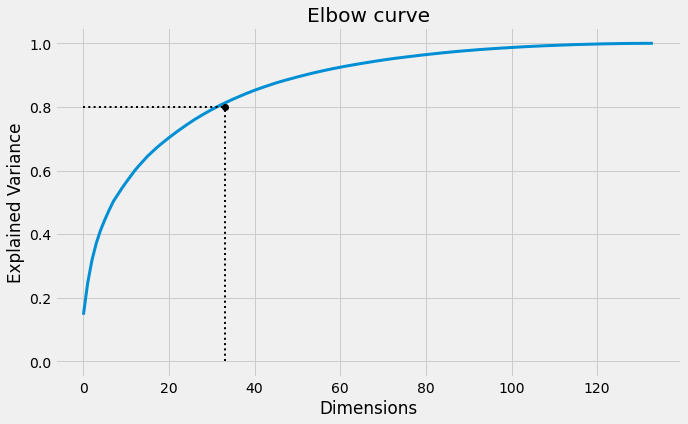

In [11]:
#graphically displaying the optimal components 
plt.style.use("fivethirtyeight")
plt.figure(figsize=(10,6))
plt.plot(cumsum, linewidth=3)
plt.title("Elbow curve")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, threshold], "k:", linewidth=2)
plt.plot([0, d], [threshold, threshold], "k:",linewidth=2)
plt.plot(d, threshold, "ko")
plt.grid(True)
plt.show()

In [12]:
d

33

In [13]:
#creating a dataframe with d number of components. 
pca = PCA(n_components=d)
prinicpalComponents = pca.fit_transform(aisle_share_pivot.fillna(0))

PCA_components = pd.DataFrame(prinicpalComponents)

In [14]:
PCA_components

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.122382,0.028613,-0.047848,0.012767,-0.075254,-0.111799,-0.100819,0.088229,-0.063967,-0.002139,...,-0.001779,0.080715,0.028148,0.099310,0.024944,-0.030355,-0.013662,0.010971,0.010691,-0.002334
1,-0.034421,0.111616,-0.064131,-0.109468,0.073280,-0.029579,-0.049195,-0.058600,-0.010489,-0.018513,...,0.038614,0.008161,-0.004574,-0.003306,-0.001336,0.000915,-0.006349,-0.025157,-0.010387,0.025535
2,0.063256,0.104112,0.000496,-0.014156,-0.047744,0.111108,-0.031838,0.012989,0.011865,0.004836,...,0.059197,-0.002612,0.000172,0.016957,-0.006013,-0.002947,0.003871,-0.001635,-0.014500,-0.013311
3,-0.094301,0.052755,0.001040,-0.005058,-0.071587,-0.017784,-0.025076,-0.038990,0.010090,-0.013999,...,0.004940,0.005332,0.000945,0.006973,-0.015739,0.009545,-0.000710,-0.062424,0.069752,0.035975
4,0.089432,-0.031068,-0.022805,-0.011825,0.042319,0.111464,-0.015767,0.100993,0.025106,-0.036476,...,-0.005576,0.008939,0.002081,-0.006617,-0.001710,0.001222,0.005169,0.005751,-0.010009,-0.008285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.001716,0.084855,-0.065398,-0.068637,0.114985,-0.028521,0.020655,0.023940,-0.027594,-0.016774,...,-0.003205,-0.026165,-0.006209,0.027838,-0.000857,-0.005609,-0.015852,-0.021426,0.002321,0.034268
206205,-0.089658,-0.046734,-0.048290,0.012790,-0.059583,-0.000545,-0.013951,-0.042905,0.143123,-0.059991,...,0.000636,0.045050,-0.009798,0.031532,0.030337,-0.032780,0.000112,-0.014137,0.000896,-0.015297
206206,-0.024827,-0.013519,-0.003968,-0.030920,0.032989,0.020683,0.037639,0.032876,-0.022812,-0.002566,...,0.007539,-0.002471,0.011801,-0.009862,0.005687,-0.003469,-0.004487,-0.007493,-0.007019,-0.002971
206207,-0.009310,-0.003375,-0.045594,-0.012232,0.013769,0.055683,0.008127,0.029506,-0.010663,0.020768,...,-0.012498,-0.002464,-0.007383,0.012495,-0.000346,-0.005336,0.005266,0.001336,-0.018026,0.000052


In [15]:
#sns.pairplot(PCA_components[range(d)])

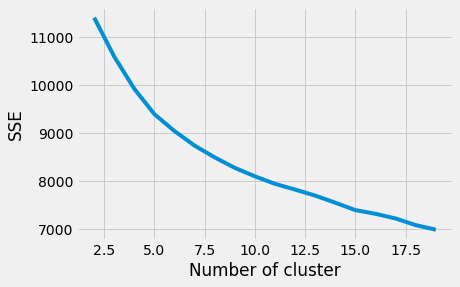

In [16]:
#finding optimal number of clusters. 
sse = {}
labels = {}
for k in range(2,20):
    kmeans = KMeans(n_clusters = k).fit(PCA_components[range(d)])
    sse[k] = kmeans.inertia_
    labels[k] = kmeans.labels_

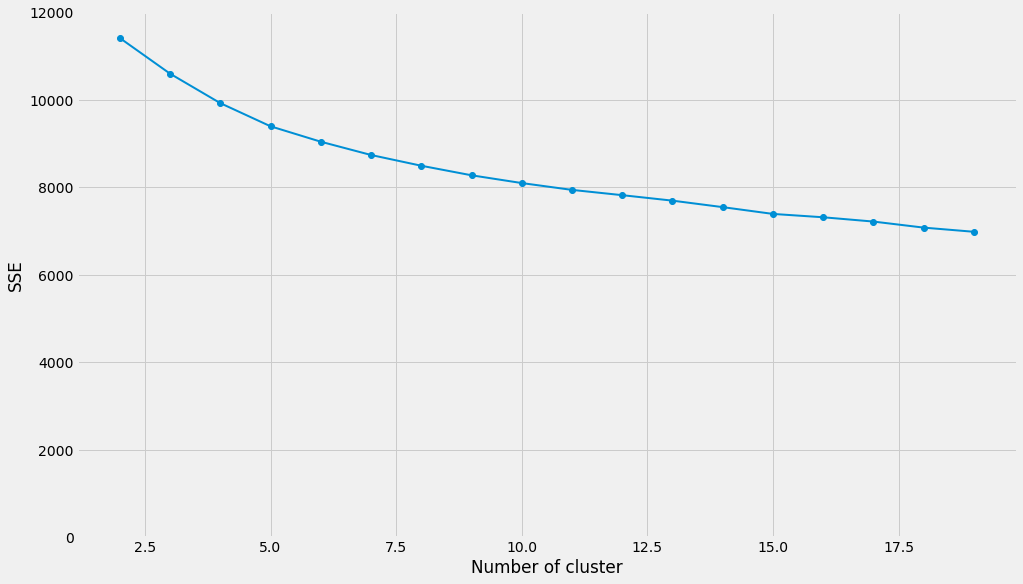

In [29]:
plt.figure(figsize=(15,9))
plt.plot(list(sse.keys()), list(sse.values()), "-o", linewidth=2)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.ylim(0, 12000)
plt.show()

In [ ]:
#pip install git+git://github.com/milesgranger/gap_statistic.git

In [41]:
from gap_statistic import OptimalK
optimalK = OptimalK(n_jobs=-1, parallel_backend='joblib')
n_clusters = optimalK(PCA_components, cluster_array=np.arange(1, 25))

In [42]:
print('Optimal clusters: ', n_clusters)

Optimal clusters:  24


In [43]:
optimalK.gap_df.head(24)

,n_clusters,gap_value,gap*,ref_dispersion_std,sk,sk*,diff,diff*
0,1.0,3.909928,633290.234794,317.283489,0.000567,731260.666844,-0.090626,728042.451891
1,2.0,4.000987,612487.626250,233.886589,0.000433,707239.843347,-0.043502,705650.548458
2,3.0,4.045127,602213.884950,338.707349,0.000638,695376.807157,-0.039754,693785.709504
3,4.0,4.086203,591926.585340,689.067719,0.001322,683498.409895,-0.031191,682317.767935
4,5.0,4.118177,584296.753924,402.637393,0.000783,674687.936519,-0.039156,673980.822204
5,6.0,4.157706,579726.697690,190.217372,0.000373,669410.765970,-0.030536,668641.595035
6,7.0,4.189512,574752.256902,641.799061,0.001270,663667.154247,-0.020180,663052.807327
7,8.0,4.210510,570782.630142,410.254065,0.000817,659083.180568,-0.002323,658555.431026
8,9.0,4.213673,567371.146558,419.470808,0.000841,655143.947442,-0.019644,654698.468242
9,10.0,4.233618,564492.534949,148.705134,0.000300,651819.856633,-0.009920,651309.102441


In [ ]:
optimalK.gap_df.head()


In [17]:
##check of other clustering alogrhitm (e.g. DBSCN)

In [18]:
aisle_share_pivot = aisle_share_pivot.fillna(0)

In [47]:
labels[8]

array([6, 5, 3, ..., 2, 2, 1], dtype=int32)

In [49]:
k = 11

In [50]:
#concatting cluster onto 
cluster_df = pd.concat([PCA_components[range(d)], pd.Series(labels[k]).rename('cluster')], axis = 1)

cluster_df = pd.concat([pd.Series(aisle_share_pivot.index),cluster_df],axis = 1)

In [51]:
cluster_df

,user_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,cluster
0,1,-0.122382,0.028613,-0.047848,0.012767,-0.075254,-0.111799,-0.100819,0.088229,-0.063967,...,0.080715,0.028148,0.099310,0.024944,-0.030355,-0.013662,0.010971,0.010691,-0.002334,0
1,2,-0.034421,0.111616,-0.064131,-0.109468,0.073280,-0.029579,-0.049195,-0.058600,-0.010489,...,0.008161,-0.004574,-0.003306,-0.001336,0.000915,-0.006349,-0.025157,-0.010387,0.025535,2
2,3,0.063256,0.104112,0.000496,-0.014156,-0.047744,0.111108,-0.031838,0.012989,0.011865,...,-0.002612,0.000172,0.016957,-0.006013,-0.002947,0.003871,-0.001635,-0.014500,-0.013311,1
3,4,-0.094301,0.052755,0.001040,-0.005058,-0.071587,-0.017784,-0.025076,-0.038990,0.010090,...,0.005332,0.000945,0.006973,-0.015739,0.009545,-0.000710,-0.062424,0.069752,0.035975,3
4,5,0.089432,-0.031068,-0.022805,-0.011825,0.042319,0.111464,-0.015767,0.100993,0.025106,...,0.008939,0.002081,-0.006617,-0.001710,0.001222,0.005169,0.005751,-0.010009,-0.008285,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,0.001716,0.084855,-0.065398,-0.068637,0.114985,-0.028521,0.020655,0.023940,-0.027594,...,-0.026165,-0.006209,0.027838,-0.000857,-0.005609,-0.015852,-0.021426,0.002321,0.034268,2
206205,206206,-0.089658,-0.046734,-0.048290,0.012790,-0.059583,-0.000545,-0.013951,-0.042905,0.143123,...,0.045050,-0.009798,0.031532,0.030337,-0.032780,0.000112,-0.014137,0.000896,-0.015297,3
206206,206207,-0.024827,-0.013519,-0.003968,-0.030920,0.032989,0.020683,0.037639,0.032876,-0.022812,...,-0.002471,0.011801,-0.009862,0.005687,-0.003469,-0.004487,-0.007493,-0.007019,-0.002971,6
206207,206208,-0.009310,-0.003375,-0.045594,-0.012232,0.013769,0.055683,0.008127,0.029506,-0.010663,...,-0.002464,-0.007383,0.012495,-0.000346,-0.005336,0.005266,0.001336,-0.018026,0.000052,6


In [53]:
#Adding cluster number to our asile share per user dataframe 
cluster_aisle_br = aisle_share_per_user.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [54]:
cluster_aisle_br

,user_id,aisle,aisle_share,cluster
0,1,candy chocolate,0.028571,0
1,1,cereal,0.057143,0
2,1,cream,0.042857,0
3,1,fresh fruits,0.071429,0
4,1,milk,0.014286,0
...,...,...,...,...
5919835,206209,soft drinks,0.080292,3
5919836,206209,soy lactosefree,0.072993,3
5919837,206209,spices seasonings,0.007299,3
5919838,206209,trash bags liners,0.007299,3


In [55]:
all_orders_cluster = all_orders.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [56]:
all_orders_cluster

,order_id,product_id,add_to_cart_order,reordered,user_id,product_name,aisle_id,department_id,department,aisle,cluster
0,2,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
1,104690,33120,2,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
2,132412,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
3,2808715,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
4,2894949,33120,5,0,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
...,...,...,...,...,...,...,...,...,...,...,...
33819101,2942910,36885,1,1,95228,Rose,134,5,alcohol,specialty wines champagnes,3
33819102,77392,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,3
33819103,679020,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,3
33819104,1264096,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,3


In [59]:
dummy_df = all_orders_cluster[["order_id", "product_id", "cluster"]]

In [61]:
dummy_df.to_csv("dummy_k11.csv")